## Stuttered image analysis

Craig Lage 10-May-22

HyeYun Park added for centroid x,y, elipticity analysis June-29-2022

In [1]:
import sys, time, os, asyncio, glob
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.time import Time, TimeDelta
from astropy.coordinates import AltAz, ICRS, EarthLocation, Angle, FK5, SkyCoord
import astropy.units as u
from lsst.obs.lsst.translators.latiss import AUXTEL_LOCATION
from lsst.daf.butler import Butler
import lsst.afw.detection as afwDetect
import lsst.afw.math as afwMath
from astropy.io import fits
from lsst.ip.isr.isrTask import IsrTask
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask, CharacterizeImageConfig

In [2]:
butler = Butler('/repo/main', collections="LATISS/raw/all")

In [3]:
# Now get the image data and the metadata

expId = 2022050500699
exp = butler.get('raw', detector=0, exposure=expId)
mData = exp.getMetadata()
date_beg = Time(mData['DATE-BEG'], format='isot', scale='tai')
time = date_beg.utc
print(expId, time)

2022050500699 2022-05-06T04:22:36.387


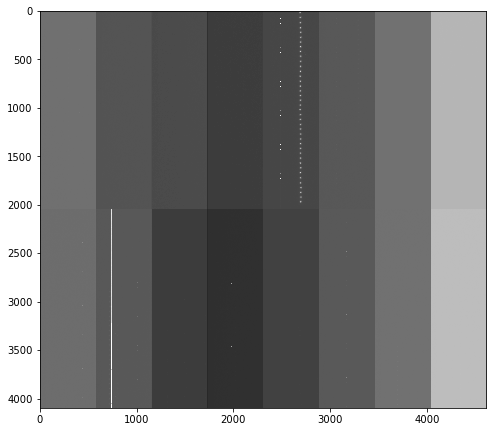

In [4]:
plt.figure(figsize=(8,8))
arr = exp.image.array#[0:2000,2500:2750]
img = plt.imshow(arr, norm=LogNorm(vmin=10000, vmax=25000),  interpolation='Nearest', cmap='gray')


Background = 12911.0
Min = -18.0, Max = 5903.0


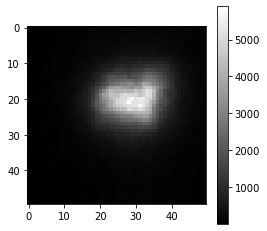

In [5]:
# Manually find a good bounding box
shift = 50
xmin = 2655
yfirst = 1995
yfinish = yfirst - 38 * shift
ystart = yfinish - shift
bgfirst = 1960
bgwidth = 30
bgstart = bgfirst - 38 * shift
bgfinish = bgstart + bgwidth
bgxmin = 2550
bgxmax = 3000


plt.figure(figsize=(4,4))
arr = exp.image.array[ystart:yfinish, xmin:xmin+shift]
bg = exp.image.array[bgstart:bgfinish, bgxmin:bgxmax]
background = np.nanmedian(bg)
print(f"Background = {background}")
arr = arr - background
print(f"Min = {arr.min()}, Max = {arr.max()}")
arr = np.clip(arr, 0.1, 200000)

img = plt.imshow(arr,   interpolation='Nearest', cmap='gray')
plt.colorbar()

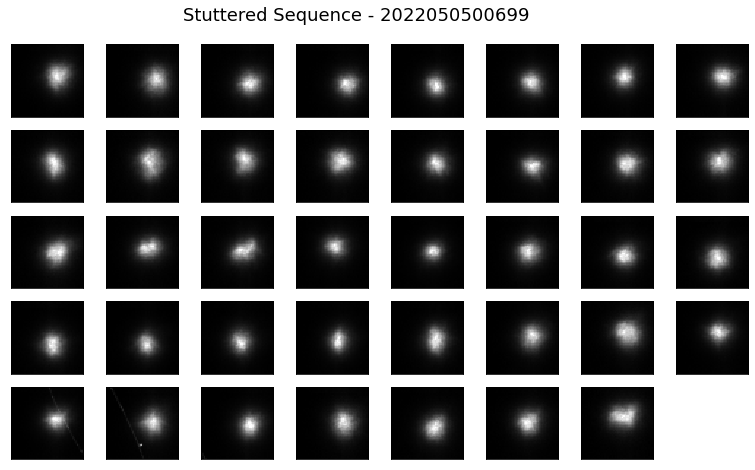

In [6]:
# Now run the whole sequence
shift = 50
xmin = 2655
yfirst = 1995
bgfirst = 1960
bgwidth = 30
bgxmin = 2550
bgxmax = 3000


plt.figure(figsize=(11, 8.5))
plt.suptitle(f"Stuttered Sequence - {expId}", fontsize = 18)
xcentroid = []
ycentroid = []
for i in range(39):
    yfinish = yfirst - i * shift
    ystart = yfinish - shift
    bgstart = bgfirst - i * shift
    bgfinish = bgstart + bgwidth
    arr = exp.image.array[ystart:yfinish, xmin:xmin+shift]
    bg = exp.image.array[bgstart:bgfinish, bgxmin:bgxmax]
    background = np.nanmedian(bg)
    #print(background)
    arr = arr - background
    arr = np.clip(arr, 0.1, 200000)
                           
    xsum = 0
    ysum = 0
    imagesum = 0
    for ii in range(50):
        for jj in range(50):
            imagesum += arr[ii,jj]
            xsum += ii * arr[ii,jj]
            ysum += jj * arr[ii,jj]
    xsum /= imagesum
    ysum /= imagesum
    xcentroid.append(xsum)
    ycentroid.append(ysum)

    nx = i % 8
    ny = int(i / 8)
    ax = plt.axes([0.05 + 0.12 * nx, 0.80 - 0.14 * ny, 0.118, 0.118], aspect = 1)
    ax.imshow(arr,   interpolation='Nearest', cmap='gray')
    #plotcounter += 1
    ax.set_xticks([])
    ax.set_yticks([])
plt.savefig(f"/home/kakoon/auxTel/stuttered/Stuttered_BG_{expId}.pdf")
    

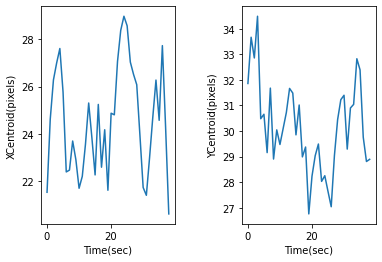

In [7]:
plt.subplots_adjust(wspace=0.5)
plt.subplot(1,2,1)
plt.plot(xcentroid)
plt.xlabel("Time(sec)")
plt.ylabel("XCentroid(pixels)")
plt.subplot(1,2,2)
plt.plot(ycentroid)
plt.xlabel("Time(sec)")
plt.ylabel("YCentroid(pixels)")

plt.savefig(f"/home/kakoon/auxTel/stuttered/Stuttered_Centroids_BG_{expId}.pdf")


In [8]:
isrConfig = IsrTask.ConfigClass()
isrConfig.doLinearize = False
isrConfig.doBias = False#True
isrConfig.doFlat = False 
isrConfig.doDark = False
isrConfig.doFringe = False
isrConfig.doDefect = False
isrConfig.doWrite = False
isrConfig.doApplyGains = True

isrTask = IsrTask(config=isrConfig)

In [9]:
charConfig = CharacterizeImageConfig()
charConfig.installSimplePsf.fwhm = 1.0
charConfig.doMeasurePsf = False
charConfig.doApCorr = False
charConfig.doDeblend = False
charConfig.repair.doCosmicRay = True
charConfig.repair.cosmicray.nCrPixelMax=100000
charConfig.repair.doInterpolate = False   
charConfig.detection.background.binSize = 10 #15#32
charConfig.detection.minPixels = 5 #10
charTask = CharacterizeImageTask(config=charConfig)

In [10]:
def detectObjectsInExp(exp, nSigma=10, nPixMin=10, grow=0):
    """Return the footPrintSet for the objects in a postISR exposure."""
    median = np.nanmedian(exp.image.array)
    exp.image -= median

    threshold = afwDetect.Threshold(nSigma, afwDetect.Threshold.STDEV)
    footPrintSet = afwDetect.FootprintSet(exp.getMaskedImage(), threshold, "DETECTED", nPixMin)
    if grow > 0:
        isotropic = True
        footPrintSet = afwDetect.FootprintSet(footPrintSet, grow, isotropic)

    exp.image += median  # add back in to leave background unchanged
    return footPrintSet

In [32]:
seqnum=698
dataId={'day_obs': 20220505, 'seq_num': seqnum, 'detector': 0}
raw = butler.get('raw', dataId)
postIsr = isrTask.run(raw).exposure
charResult = charTask.run(postIsr)
spotCatalog = charResult.sourceCat

xx=spotCatalog['base_SdssShape_xx']
yy=spotCatalog['base_SdssShape_yy']
xy=spotCatalog['base_SdssShape_xy']
x=spotCatalog['base_SdssCentroid_x']
y=spotCatalog['base_SdssCentroid_y']
#area=spotCatalog['base_FootprintArea_value']
psfXX=spotCatalog['base_SdssShape_psf_xx']
psfYY=spotCatalog['base_SdssShape_psf_yy']
psfXY=spotCatalog['base_SdssShape_psf_xy']
size=np.power(xx*yy-xy**2,0.25)
#size=np.power(psfXX*psfYY-psfXY**2,0.25)
norm = plt.Normalize(vmin=1., vmax=2.2) #np.nanmin(size), vmax=np.nanmax(size))


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/detection.py:410: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/detection.py:447: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()


/tmp/ipykernel_20287/2842719117.py:17: RuntimeWarning: invalid value encountered in power
  size=np.power(xx*yy-xy**2,0.25)


mean x= 2759.981559517307


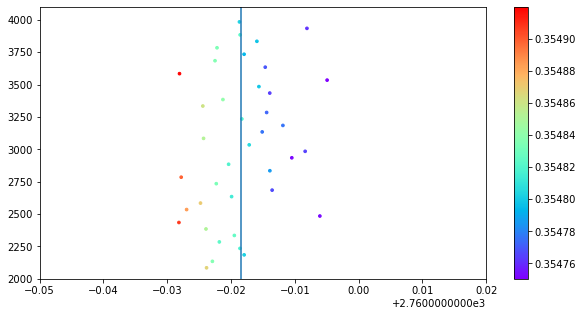

In [53]:
xinrange=x[np.where(np.logical_and(x>=2759.9, x<=2760.1))]
yinrange=y[np.where(np.logical_and(x>=2759.9, x<=2760.1))]
sizeinrange=size[np.where(np.logical_and(x>=2759.9, x<=2760.1))]
norm = plt.Normalize(vmin=np.nanmin(sizeinrange), vmax=np.nanmax(sizeinrange))
plt.figure(figsize=(10,5))    
plt.scatter(xinrange,yinrange,c=sizeinrange, norm=norm, cmap=plt.cm.rainbow, s=20*sizeinrange) #plt.cm.jet
plt.ylim(2000,4100)
plt.xlim(2759.95,2760.02)
plt.axvline(np.mean(xinrange))
print('mean x=',np.mean(xinrange))
plt.colorbar()

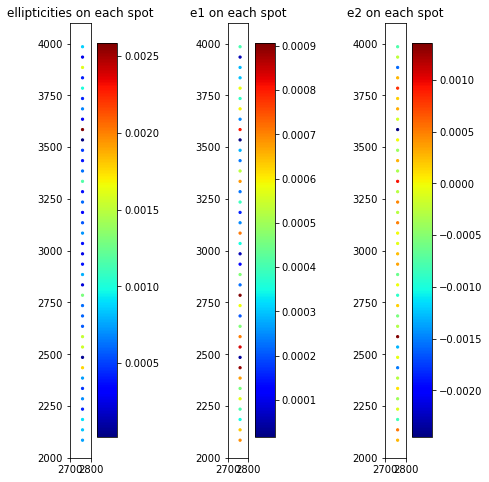

In [59]:
xx=spotCatalog['base_SdssShape_xx']
yy=spotCatalog['base_SdssShape_yy']
xy=spotCatalog['base_SdssShape_xy']
from lsst.validate.drp.util import ellipticity
ell=ellipticity(xx,xy,yy)

xxinrange=xx[np.where(np.logical_and(x>=2759.9, x<=2760.1))]
yyinrange=yy[np.where(np.logical_and(x>=2759.9, x<=2760.1))]
xyinrange=xy[np.where(np.logical_and(x>=2759.9, x<=2760.1))]

#print (np.nanmin(ell[2]),np.nanmax(ell[2]))
xs = spotCatalog['base_SdssCentroid_x']
ys = spotCatalog['base_SdssCentroid_y']
xsinrange=xs[np.where(np.logical_and(x>=2759.9, x<=2760.1))]
ysinrange=ys[np.where(np.logical_and(x>=2759.9, x<=2760.1))]

plt.figure(figsize=(8,8))    
plt.subplot(1,3,1,aspect=1)
plt.title('ellipticities on each spot')
plt.ylim(2000,4100)
plt.xlim(2700,2800)
e = np.abs(ell[0][np.where(np.logical_and(x>=2759.9, x<=2760.1))]) #(ell[0]+0.5)/np.nanmax(ell[0]) * 100.0
norm = plt.Normalize(vmin=-1.0, vmax=1.0)

plt.scatter(xsinrange,ysinrange,c=e, norm=None, cmap=plt.cm.jet, s=5)
plt.colorbar()
plt.subplot(1,3,2,aspect=1)
plt.title('e1 on each spot')
e1 = ell[1][np.where(np.logical_and(x>=2759.9, x<=2760.1))] #(ell[0]+0.5)/np.nanmax(ell[0]) * 100.0
plt.scatter(xsinrange,ysinrange,c=e1, norm=None, cmap=plt.cm.jet, s=5)
plt.ylim(2000,4100)
plt.xlim(2700,2800)
plt.colorbar()


plt.subplot(1,3,3,aspect=1)
plt.title('e2 on each spot')
e2 = ell[2][np.where(np.logical_and(x>=2759.9, x<=2760.1))] #(ell[0]+0.5)/np.nanmax(ell[0]) * 100.0
plt.scatter(xsinrange,ysinrange,c=e2, norm=None, cmap=plt.cm.jet, s=5)
plt.ylim(2000,4100)
plt.xlim(2700,2800)
plt.colorbar()


In [72]:
print("x        |y        |size  |xx    |yy    |xy    |e     |e1    |e2")
for i in range(len(xinrange)):
    print("%.4f|%.4f|%.4f|%.4f|%.4f|%.4f|%.4f|%.4f|%.4f"%(xinrange[i],yinrange[i],sizeinrange[i],xxinrange[i],yyinrange[i],xyinrange[i],e[i],e1[i],e2[i]))

x        |y        |size  |xx    |yy    |xy    |e     |e1    |e2
2759.9762|2084.9985|0.3549|0.1260|0.1258|0.0000|0.0007|0.0007|0.0003
2759.9771|2134.9972|0.3548|0.1260|0.1258|0.0001|0.0008|0.0006|0.0005
2759.9821|2185.0060|0.3548|0.1259|0.1258|-0.0001|0.0009|0.0004|-0.0008
2759.9814|2235.0007|0.3548|0.1259|0.1258|-0.0000|0.0004|0.0004|-0.0001
2759.9782|2285.0023|0.3548|0.1260|0.1258|-0.0000|0.0007|0.0006|-0.0004
2759.9805|2334.9996|0.3548|0.1260|0.1258|0.0000|0.0005|0.0005|0.0001
2759.9761|2385.0014|0.3549|0.1260|0.1258|-0.0000|0.0007|0.0007|-0.0003
2759.9718|2435.0069|0.3549|0.1261|0.1258|-0.0002|0.0018|0.0009|-0.0015
2759.9939|2485.0011|0.3548|0.1259|0.1258|-0.0000|0.0001|0.0000|-0.0000
2759.9730|2535.0061|0.3549|0.1260|0.1258|-0.0002|0.0016|0.0008|-0.0013
2759.9752|2584.9932|0.3549|0.1260|0.1258|0.0002|0.0015|0.0007|0.0014
2759.9801|2635.0020|0.3548|0.1260|0.1258|-0.0000|0.0006|0.0005|-0.0003
2759.9864|2685.0051|0.3548|0.1259|0.1258|-0.0001|0.0006|0.0002|-0.0006
2759.9777|2734.9991|

In [38]:
# seqnum=134
for seqnum in range(695,699):
    for ccd in range(1):
        dataId = {'day_obs': 20220505, 'seq_num': seqnum, 'detector': ccd}
        raw = butler.get('raw', dataId)
        postIsr = isrTask.run(raw).exposure
        charResult = charTask.run(postIsr)
        spotCatalog = charResult.sourceCat
        fpSet = detectObjectsInExp(postIsr, nPixMin=20)
        footprints = fpSet.getFootprints()

        nTracks = len(footprints)
        print(f'Writing {nTracks} tracks to cosmicFits2/{seqnum}')

        for srcNum, footprint in enumerate(footprints):
            flux = footprint.getArea
            box = footprint.getBBox()
            cutout = postIsr[box]
            flux = np.sum(cutout.image.array)
            width, height = box.getDimensions()
            aspect_ratio = max(width/height, height/width)  # whichever is longest
            # print(f'{srcNum}: area={footprint.getArea()}, aspect:{aspect_ratio:.1f}, flux={flux:.1f}')
            name = f'cosmicFits2/{seqnum}/{ccd}_{box.beginX}_{box.beginY}.fits'
            # print('Writing to:', name)
            if not os.path.exists(f'cosmicFits2/{seqnum}'):
                os.makedirs(f'cosmicFits2/{seqnum}')
            if not os.path.exists(name):
                fits.HDUList([fits.PrimaryHDU(),fits.ImageHDU(cutout.image.array)]).writeto(name)

/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/detection.py:410: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/detection.py:447: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()


Writing 124 tracks to cosmicFits2/695


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/detection.py:410: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/detection.py:447: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()


Writing 132 tracks to cosmicFits2/696


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/detection.py:410: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/detection.py:447: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()


Writing 139 tracks to cosmicFits2/697


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/detection.py:410: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/detection.py:447: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()


Writing 135 tracks to cosmicFits2/698


0: 1 area=234, aspect:3.3, flux=280307.8


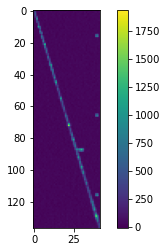

1: 1 area=29, aspect:9.0, flux=29894.6


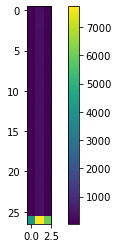

2: 1 area=42, aspect:1.8, flux=12232.3


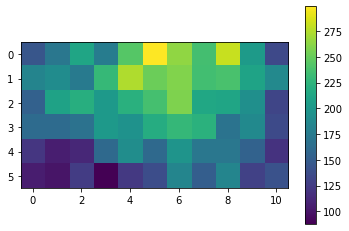

3: 1 area=51, aspect:16.3, flux=39955.8


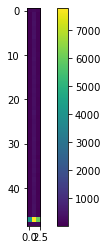

4: 1 area=38, aspect:2.8, flux=36443.7


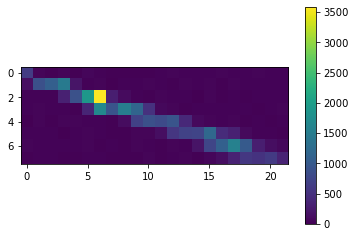

5: 1 area=1090, aspect:1.1, flux=1304689.0


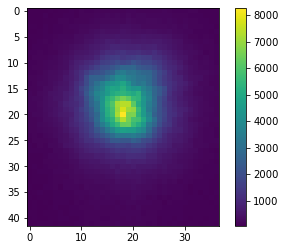

6: 1 area=44, aspect:1.1, flux=15588.2


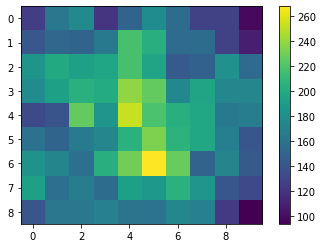

7: 1 area=50, aspect:16.0, flux=39052.5


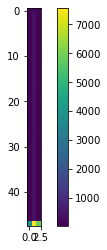

8: 1 area=41, aspect:1.1, flux=12428.6


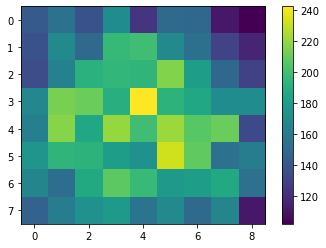

9: 1 area=50, aspect:16.0, flux=40191.2


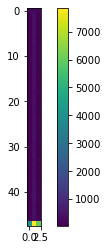

In [30]:
for srcNum, footprint in enumerate(footprints[:10]):
    flux = footprint.getArea
    cutout = postIsr[footprint.getBBox()]
    flux = np.sum(cutout.image.array)
    width, height = footprint.getBBox().getDimensions()
    aspect_ratio = max(width/height, height/width)  # whichever is longest
    print(f'{srcNum}: {1} area={footprint.getArea()}, aspect:{aspect_ratio:.1f}, flux={flux:.1f}')
    plt.imshow(cutout.image.array)
    plt.colorbar()
    plt.show()

In [ ]:
#expId = 2022050500699
#exp = butler.get('raw', detector=0, exposure=expId)
#mData = exp.getMetadata()
#print(mData)
data_id = {'instrument': 'LATISS', 'detector': 0, 'exposure': expId}
test=butler.get('raw',dataId=data_id)
print (test.getMetadata())


In [ ]:
butler.get(
    "deepCoadd_obj", exposure=expId,collections="LATISS/raw/all",
    parameters={
        "columns": {"dataset": "meas",
                    "filter": ["HSC-R", "HSC-I"],
                    "column": ["base_SdssShape_xx", "base_SdssShape_yy"]}
    }
)

In [ ]:
spotCatalog = charResult.sourceCat
xx=spotCatalog['base_SdssShape_xx']
yy=spotCatalog['base_SdssShape_yy']
xy=spotCatalog['base_SdssShape_xy']
from lsst.validate.drp.util import ellipticity
ell=ellipticity(xx,xy,yy)

#print (np.nanmin(ell[2]),np.nanmax(ell[2]))
xs = spotCatalog['base_SdssCentroid_x']
ys = spotCatalog['base_SdssCentroid_y']
spotNum = 11 #277
deltaX = deltaY = 25
plotX = range(deltaX)
xCen = int(round(xs[spotNum]))
yCen = int(round(ys[spotNum]))

xMin = int(xCen - (deltaX-1)/2)
xMax = xMin + deltaX
yMin = int(yCen - (deltaY-1)/2)
yMax = yMin + deltaY
plt.figure(figsize=(24,8))    
numCat = len(spotCatalog)
plt.subplot(1,3,1,aspect=1)
plt.title('ellipticities on each spot - numCat = %d'%numCat)
e = np.abs(ell[0]) #(ell[0]+0.5)/np.nanmax(ell[0]) * 100.0
norm = plt.Normalize(vmin=-1.0, vmax=1.0)

plt.scatter(spotCatalog['base_SdssCentroid_x'],spotCatalog['base_SdssCentroid_y'],c=e, norm=None, cmap=plt.cm.jet, s=5)
plt.colorbar()
plt.subplot(1,3,2,aspect=1)
plt.title('e1 on each spot - numCat = %d'%numCat)
e1 = ell[1] #(ell[0]+0.5)/np.nanmax(ell[0]) * 100.0
plt.scatter(spotCatalog['base_SdssCentroid_x'],spotCatalog['base_SdssCentroid_y'],c=e1, norm=None, cmap=plt.cm.jet, s=5)
plt.colorbar()
plt.subplot(1,3,3,aspect=1)
plt.title('e2 on each spot - numCat = %d'%numCat)
e2 = ell[2] #(ell[0]+0.5)/np.nanmax(ell[0]) * 100.0
plt.scatter(spotCatalog['base_SdssCentroid_x'],spotCatalog['base_SdssCentroid_y'],c=e2, norm=None, cmap=plt.cm.jet, s=5)
plt.colorbar()